<a href="https://colab.research.google.com/github/Prax0028/Violence_Detection_Model_Codes/blob/main/ProjectV4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Clone the dataset from GitHub
!git clone https://github.com/Prax0028/violence_dataset.git

Cloning into 'violence_dataset'...
remote: Enumerating objects: 10971, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 10971 (delta 7), reused 0 (delta 0), pack-reused 10956 (from 1)
Receiving objects: 100% (10971/10971), 645.81 MiB | 19.75 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (11065/11065), done.


In [ ]:

# Step 2: Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2
import os
from PIL import Image
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report


In [ ]:
class CNNLSTMModel(nn.Module):
    def __init__(self):
        super(CNNLSTMModel, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        # Calculate the flattened size based on a dummy input
        dummy_input = torch.zeros(1, 3, 224, 224)
        flattened_size = self._get_flattened_size(dummy_input)

        # Update LSTM input size based on the calculated flattened size
        self.lstm = nn.LSTM(input_size=flattened_size, hidden_size=128, num_layers=1, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 2)  # Output layer with 2 units (for binary classification)
        )

        self.gradient = None

    def _get_flattened_size(self, x):
        x = self.feature_extractor(x)
        return x.view(x.size(0), -1).size(1)

    def activations_hook(self, grad):
        self.gradient = grad

    def get_activation_gradients(self):
        return self.gradient

    def get_activation(self, x):
        return self.feature_extractor(x)

    def forward(self, images):
        batch_size, seq_len, c, h, w = images.size()
        x = images.view(batch_size * seq_len, c, h, w)  # Combine batch and sequence dimensions for CNN processing
        x = self.feature_extractor(x)
        x = x.view(batch_size, seq_len, -1)  # Flatten feature map for LSTM input (batch_size, sequence_length, input_size)
        x, (hn, cn) = self.lstm(x)  # LSTM output
        x = hn[-1]  # Use the last hidden state
        x = self.classifier(x)
        return x, x  # Return activations for Grad-CAM if needed


In [ ]:
CNNLSTMModel()

CNNLSTMModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (lstm): LSTM(401408, 128, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [ ]:
class FrameSequenceDataset(Dataset):
    def __init__(self, csv_file, data_dir, sequence_length=10, transform=None):
        self.data = pd.read_csv(csv_file)
        self.data_dir = data_dir
        self.sequence_length = sequence_length
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),  # Ensure all frames are resized to 224x224
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.grouped_data = self.data.groupby(self.data['img_path'].apply(lambda x: x.split('_')[1]))

    def __len__(self):
        return len(self.grouped_data)

    def __getitem__(self, idx):
        video_name = list(self.grouped_data.groups.keys())[idx]
        frames_info = self.grouped_data.get_group(video_name)
        frames = []

        for _, row in frames_info.iterrows():
            img_path = os.path.join(self.data_dir, row['img_path'])
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            frames.append(image)
            if len(frames) >= self.sequence_length:
                break

        if len(frames) < self.sequence_length:
            padding = [torch.zeros_like(frames[0])] * (self.sequence_length - len(frames))
            frames.extend(padding)
        frames_tensor = torch.stack(frames)
        label = frames_info['label'].iloc[0]
        return frames_tensor, torch.tensor(label, dtype=torch.long)


In [ ]:

# Step 5: Grad-CAM function
def get_gradcam(model, image, size):
    model.eval()
    pred, activations = model(image)
    predicted_class = pred.argmax(dim=1)
    model.zero_grad()
    pred[0][predicted_class].backward()
    gradients = model.get_activation_gradients()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = activations.detach()

    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze().cpu()
    heatmap = nn.ReLU()(heatmap)
    heatmap /= torch.max(heatmap)
    heatmap = heatmap.numpy()
    heatmap = cv2.resize(heatmap, (size, size))

    return heatmap


In [ ]:

# Step 6: Function to plot Grad-CAM
def plot_heatmap(denorm_image, pred, heatmap, actual_label):
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20, 20), ncols=3)
    classes = ['non-violence', 'violence']
    ps = torch.nn.Softmax(dim=1)(pred).cpu().detach().numpy()
    ax1.imshow(denorm_image)

    ax2.barh(classes, ps[0])
    predicted_class_index = np.argmax(ps[0])
    predicted_class_label = classes[predicted_class_index]
    actual_class_label = classes[actual_label]

    caption = (f"Predicted Class: {predicted_class_label} ({ps[0][predicted_class_index]:.2f} probability)\n"
               f"Actual Class: {actual_class_label}")
    ax2.text(0.5, -0.2, caption, ha='center', va='top', transform=ax2.transAxes, fontsize=12)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(classes)))
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    ax3.imshow(denorm_image)
    ax3.imshow(heatmap, cmap='jet', alpha=0.7)
    plt.show()


In [ ]:
def visualize_gradcam(model, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Take a single sequence for visualization (e.g., the first sequence in the batch)
        image_sequence = images[0]  # Shape: (seq_len, channels, height, width)
        label = labels[0].item()

        # Choose a specific frame to visualize (e.g., the first frame in the sequence)
        image = image_sequence[0].unsqueeze(0)  # Shape: (1, channels, height, width)

        # Denormalize the image for display
        denorm_image = image[0].permute(1, 2, 0).cpu().numpy()
        denorm_image = denorm_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        denorm_image = np.clip(denorm_image, 0, 1)

        # Get prediction and heatmap
        pred, _ = model(image.unsqueeze(0))  # Add a batch dimension for the model
        heatmap = get_gradcam(model, image.unsqueeze(0), size=denorm_image.shape[0])

        # Plot the heatmap
        plot_heatmap(denorm_image, pred, heatmap, label)
        break  # Only visualize one sequence


In [ ]:

# Step 8: Load the dataset and create DataLoaders
csv_file = '/content/violence_dataset/image_labels.csv'  # Path to your CSV file
data_dir = '/content/violence_dataset/'  # Base directory containing 'violent' and 'non_violent' subdirectories


In [ ]:

dataset = FrameSequenceDataset(csv_file=csv_file, data_dir=data_dir, sequence_length=10)
train_size = int(0.7 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])


In [ ]:

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)


In [ ]:

# Step 9: Initialize the model, optimizer, and loss function
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNNLSTMModel().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Function to train the model
def train_fun(dataloader, model, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for images, labels in tqdm(dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        # Forward pass
        logits, _ = model(images)  # Unpack the tuple to get only the logits

        # Calculate loss
        loss = criterion(logits, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

# Function to evaluate the model
def eval_fun(dataloader, model, criterion):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_actual_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            logits, _ = model(images)  # Unpack the tuple to get only the logits

            loss = criterion(logits, labels)
            total_loss += loss.item()

            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            all_actual_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predictions.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy, all_actual_labels, all_predicted_labels


100%|██████████| 76/76 [00:13<00:00,  5.78it/s]


Model saved successfully!
EPOCH: 1, TRAIN_LOSS: 0.0041, TRAIN_ACCURACY: 0.9943, VALID_LOSS: 14.3399, VALID_ACCURACY: 0.9967


100%|██████████| 76/76 [00:13<00:00,  5.70it/s]


EPOCH: 2, TRAIN_LOSS: 0.0000, TRAIN_ACCURACY: 1.0000, VALID_LOSS: 14.3399, VALID_ACCURACY: 0.9967


100%|██████████| 76/76 [00:13<00:00,  5.67it/s]


EPOCH: 3, TRAIN_LOSS: 0.0000, TRAIN_ACCURACY: 1.0000, VALID_LOSS: 14.3399, VALID_ACCURACY: 0.9967


100%|██████████| 76/76 [00:13<00:00,  5.62it/s]


EPOCH: 4, TRAIN_LOSS: 0.0000, TRAIN_ACCURACY: 1.0000, VALID_LOSS: 14.3399, VALID_ACCURACY: 0.9967


100%|██████████| 76/76 [00:12<00:00,  6.01it/s]


EPOCH: 5, TRAIN_LOSS: 0.0000, TRAIN_ACCURACY: 1.0000, VALID_LOSS: 14.3399, VALID_ACCURACY: 0.9967


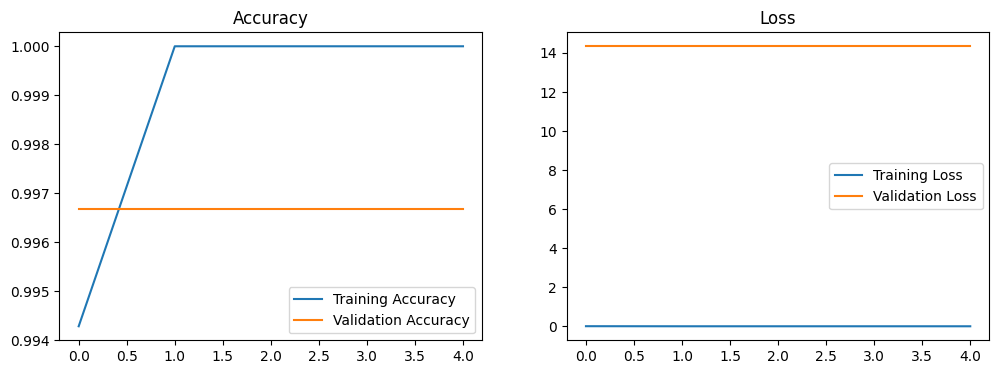

In [ ]:
# Step 10: Training loop with history tracking
EPOCHS = 5
best_valid_loss = np.Inf

# Initialize lists to track accuracy and loss
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(EPOCHS):
    # Training step
    train_loss, train_accuracy = train_fun(train_loader, model, optimizer, criterion)
    valid_loss, valid_accuracy, _, _ = eval_fun(valid_loader, model, criterion)

    # Append to history lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    # Save the best model based on validation loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'best_valid_loss': best_valid_loss
        }, 'best_model_lstm.pth')
        print("Model saved successfully!")

    # Print epoch results
    print(f"EPOCH: {epoch+1}, TRAIN_LOSS: {train_loss:.4f}, TRAIN_ACCURACY: {train_accuracy:.4f}, "
          f"VALID_LOSS: {valid_loss:.4f}, VALID_ACCURACY: {valid_accuracy:.4f}")

# Step 12: Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()
